### LSTM

```python 
np.random.seed(0)
pd.set_option('display.precision', 2)  
pd.set_option('display.float_format', '{:.2f}'.format) -
```

```python
series_has_nan = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
train_ids = series_has_nan[~series_has_nan].index.tolist()
```

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from itertools import groupby
import gc

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

np.random.seed(0)
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", "{:.2f}".format)

In [99]:
current_directory = os.getcwd()

csv_file_path = os.path.join(
    current_directory, "input", "data", "sample_submission.csv"
)

sample_submission = pd.read_csv(csv_file_path)

sample_submission.head()

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.00
1,1,038441c925bb,105,wakeup,0.00
2,2,03d92c9f6f8a,80,onset,0.50
3,3,03d92c9f6f8a,110,wakeup,0.50
4,4,0402a003dae9,90,onset,1.00


In [40]:
current_directory = os.getcwd()

csv_file_path = os.path.join(current_directory, "input", "data", "train_events.csv")

train_events = pd.read_csv(csv_file_path)

series_has_nan = train_events.groupby("series_id")["step"].apply(
    lambda x: x.isnull().any()
)
train_ids = series_has_nan[~series_has_nan].index.tolist()

train_ids

['08db4255286f',
 '0a96f4993bd7',
 '0cfc06c129cc',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '29c75c018220',
 '31011ade7c0a',
 '3452b878e596',
 '349c5562ee2c',
 '3664fe9233f9',
 '483d6545417f',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '5f94bb3e1bed',
 '655f19eabf1e',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '76237b9406d5',
 '7822ee8fe3ec',
 '89bd631d1769',
 '8e32047cbc1f',
 '939932f1822d',
 '9ee455e4770d',
 'a596ad0b82aa',
 'a9a2f7fac455',
 'a9e5f5314bcb',
 'af91d9a50547',
 'b364205aba43',
 'c535634d7dcd',
 'c6788e579967',
 'c68260cc9e8f',
 'ca730dbf521d',
 'd150801f3145',
 'd25e479ecbb7',
 'd515236bdeec',
 'd5e47b94477e']

In [72]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(
    current_directory, "input", "light_weight_data", "Zzzs_train_multi.parquet"
)


def get_multi_light_series(series_ids):
    print(f"fetch {series_ids} \n")
    multi_series = pd.read_parquet(
        parquet_file_path, filters=[("series_id", "in", series_ids)]
    )
    multi_series = multi_series.astype(
        {"series_id": "category", "step": "int16", "awake": "int16"}
    )
    multi_series = add_features(multi_series)
    return multi_series

In [73]:
def add_features(df):
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek

    df["anglez_times_enmo"] = abs(df["anglez"]) * df["enmo"]

    periods = 6  # 1/2 minute
    df["anglez_diff"] = (
        df.groupby("series_id")["anglez"].diff(periods=periods).fillna(method="bfill")
    )
    df["enmo_diff"] = (
        df.groupby("series_id")["enmo"].diff(periods=periods).fillna(method="bfill")
    )

    df["anglez_mean"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_mean"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_min"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .min()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_min"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .min()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_max"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .max()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_max"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .max()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_std"] = (
        df["anglez"]
        .rolling(periods, center=True)
        .std()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_std"] = (
        df["enmo"]
        .rolling(periods, center=True)
        .std()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )

    df["anglez_diff_rolling"] = (
        df["anglez_diff"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    df["enmo_diff_rolling"] = (
        df["enmo_diff"]
        .rolling(periods, center=True)
        .mean()
        .fillna(method="bfill")
        .fillna(method="ffill")
        .astype("float32")
    )
    return df

In [74]:
train_all = get_multi_light_series(train_ids[:8])
print(f"memory usage: {train_all.memory_usage().sum() / 1024**2: .2f} MB")

fetch ['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

memory usage:  219.76 MB


/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff_rolling"]   = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')


In [75]:
train_all.head()

,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_diff,...,anglez_mean,enmo_mean,anglez_min,enmo_min,anglez_max,enmo_max,anglez_std,enmo_std,anglez_diff_rolling,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.85,0.04,1,14,0,1.38,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.18,0.04,1,14,0,1.51,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.88,0.05,1,14,0,1.64,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.28,0.07,1,14,0,2.33,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.39,0.08,1,14,0,2.64,0.33,...,-33.69,0.07,-34.93,0.04,-30.51,0.11,1.60,0.02,0.33,0.06


Prepare Data

In [45]:
features = [
    "step",
    "hour",
    "dayofweek",
    "anglez_times_enmo",
    "anglez",
    "anglez_diff",
    "anglez_mean",
    "anglez_min",
    "anglez_max",
    "anglez_std",
    "anglez_diff_rolling",
    "enmo",
    "enmo_diff",
    "enmo_mean",
    "enmo_min",
    "enmo_max",
    "enmo_std",
    "enmo_diff_rolling",
]
target = "awake"

scaler = StandardScaler()

df_train_X_scaled = scaler.fit_transform(train_all[features])
df_train_y = train_all[target].values

Split Data

In [46]:
from torch import tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

def_device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
def_device

'mps'

In [47]:
X = tensor(df_train_X_scaled, dtype=torch.float32)
y = tensor(df_train_y, dtype=torch.long)

X.shape, y.shape

(torch.Size([2844900, 18]), torch.Size([2844900]))

In [48]:
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([2275920, 18]),
 torch.Size([2275920]),
 torch.Size([568980, 18]),
 torch.Size([568980]))

In [49]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_ds, val_ds = TimeSeriesDataset(X_train, y_train), TimeSeriesDataset(X_val, y_val)
batch_size = 12 * 60  # 1 hour

train_dl, val_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=False
), DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(def_device)
        x = x[:, None, :]  # to 3D dimension
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1, :]))
        return out

In [51]:
from tqdm import tqdm


def accuracy(out, yb):
    return (
        (out.argmax(axis=1) == yb).float().mean()
    )  # Evaluate the accuracy of the model.


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        print(f"Starting epoch {epoch+1} train")
        progress_bar = tqdm(train_dl)
        model.train(True)
        for xb, yb in progress_bar:
            xb, yb = xb.to(def_device), yb.to(def_device)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            progress_bar.set_description(f"Loss: {loss.item():.3f}")
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.0, 0.0, 0
            print(f"Starting epoch {epoch+1} eval")
            progress_bar = tqdm(valid_dl)
            for xb, yb in progress_bar:
                xb, yb = xb.to(def_device), yb.to(def_device)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        print(
            f"epoch:{epoch}, loss: {tot_loss/count:.2f}, accuracy: {tot_acc/count:.2f}"
        )
    return tot_loss / count, tot_acc / count


def predict(x):
    with torch.no_grad():
        predicted = model(x.to(def_device)).to("cpu")
    score = F.log_softmax(predicted, -1).exp()
    value = score.argmax(axis=1)
    return score, value

In [52]:
input_size = len(features)
hidden_size = 32  # like 1 2 4 32 64
num_layers = 2
output_size = 2

model = LSTM(input_size, hidden_size, num_layers, output_size)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = F.cross_entropy

model.to(def_device)
model

LSTM(
  (lstm): LSTM(18, 32, num_layers=2, batch_first=True)
  (relu): ReLU()
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [53]:
%time loss,acc = fit(4, model, loss_func, opt, train_dl, val_dl)

Starting epoch 1 train


Loss: 0.252: 100%|██████████| 3161/3161 [00:33<00:00, 93.51it/s] 


Starting epoch 1 eval


100%|██████████| 791/791 [00:04<00:00, 178.82it/s]


epoch:0, loss: 0.18, accuracy: 0.93
Starting epoch 2 train


Loss: 0.118: 100%|██████████| 3161/3161 [00:32<00:00, 96.64it/s] 


Starting epoch 2 eval


100%|██████████| 791/791 [00:04<00:00, 185.69it/s]


epoch:1, loss: 0.17, accuracy: 0.94
Starting epoch 3 train


Loss: 0.118: 100%|██████████| 3161/3161 [00:32<00:00, 98.37it/s] 


Starting epoch 3 eval


100%|██████████| 791/791 [00:04<00:00, 171.89it/s]


epoch:2, loss: 0.15, accuracy: 0.94
Starting epoch 4 train


Loss: 0.128: 100%|██████████| 3161/3161 [00:33<00:00, 93.71it/s] 


Starting epoch 4 eval


100%|██████████| 791/791 [00:04<00:00, 173.08it/s]

epoch:3, loss: 0.14, accuracy: 0.95
CPU times: user 2min, sys: 20.3 s, total: 2min 21s
Wall time: 2min 30s


In [54]:
xb, yb = next(iter(train_dl))
print(xb.shape, yb.shape)

torch.Size([720, 18]) torch.Size([720])


accuracy: 1.0


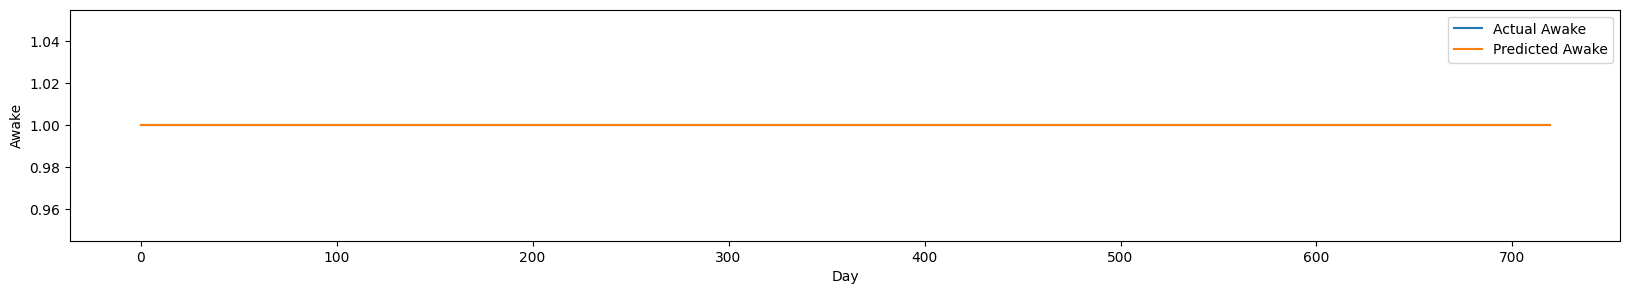

In [55]:
score, pred_value = predict(xb)
print(f"accuracy: {accuracy(score, yb)}")


def plot_predicate(act_value, pred_value):
    plt.figure(figsize=(20, 3))
    plt.plot(act_value, label="Actual Awake")
    plt.plot(pred_value, label="Predicted Awake")
    plt.xlabel("Day")
    plt.ylabel("Awake")
    plt.legend()
    plt.show()


plot_predicate(yb, pred_value)

In [56]:
def data_transform(df):
    if df.empty:
        raise ValueError("The input dataframe is empty.")
    df = add_features(df)
    if not set(features).issubset(df.columns):
        raise ValueError("Some features are not present in the dataframe.")
    df_scaler = scaler.transform(df[features])
    return tensor(df_scaler, dtype=torch.float32)

In [57]:
print(train_ids[30:32])
print(train_all.columns)
print(train_ids)

train_all.loc[train_all["series_id"] == "05e1944c3818"]


train_all

['c6788e579967', 'c68260cc9e8f']
Index(['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'awake', 'hour',
       'dayofweek', 'anglez_times_enmo', 'anglez_diff', 'enmo_diff',
       'anglez_mean', 'enmo_mean', 'anglez_min', 'enmo_min', 'anglez_max',
       'enmo_max', 'anglez_std', 'enmo_std', 'anglez_diff_rolling',
       'enmo_diff_rolling'],
      dtype='object')
['08db4255286f', '0a96f4993bd7', '0cfc06c129cc', '1087d7b0ff2e', '10f8bc1f7b07', '18b61dd5aae8', '29c75c018220', '31011ade7c0a', '3452b878e596', '349c5562ee2c', '3664fe9233f9', '483d6545417f', '55a47ff9dc8a', '5acc9d63b5fd', '5f94bb3e1bed', '655f19eabf1e', '67f5fc60e494', '72bbd1ac3edf', '76237b9406d5', '7822ee8fe3ec', '89bd631d1769', '8e32047cbc1f', '939932f1822d', '9ee455e4770d', 'a596ad0b82aa', 'a9a2f7fac455', 'a9e5f5314bcb', 'af91d9a50547', 'b364205aba43', 'c535634d7dcd', 'c6788e579967', 'c68260cc9e8f', 'ca730dbf521d', 'd150801f3145', 'd25e479ecbb7', 'd515236bdeec', 'd5e47b94477e']


,series_id,step,timestamp,anglez,enmo,awake,hour,dayofweek,anglez_times_enmo,anglez_diff,...,anglez_mean,enmo_mean,anglez_min,enmo_min,anglez_max,enmo_max,anglez_std,enmo_std,anglez_diff_rolling,enmo_diff_rolling
0,08db4255286f,0,2018-11-05 14:00:00+00:00,-30.85,0.04,1,14,0,1.38,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
1,08db4255286f,1,2018-11-05 14:00:05+00:00,-34.18,0.04,1,14,0,1.51,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
2,08db4255286f,2,2018-11-05 14:00:10+00:00,-33.88,0.05,1,14,0,1.64,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
3,08db4255286f,3,2018-11-05 14:00:15+00:00,-34.28,0.07,1,14,0,2.33,0.33,...,-33.75,0.06,-34.93,0.04,-30.85,0.08,1.46,0.01,0.33,0.06
4,08db4255286f,4,2018-11-05 14:00:20+00:00,-34.39,0.08,1,14,0,2.64,0.33,...,-33.69,0.07,-34.93,0.04,-30.51,0.11,1.60,0.02,0.33,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2844895,29c75c018220,5463,2018-05-01 13:14:35+00:00,-12.78,0.02,1,13,1,0.23,-2.80,...,-13.84,0.02,-15.10,0.02,-12.78,0.03,0.97,0.00,-1.66,-0.00
2844896,29c75c018220,5464,2018-05-01 13:14:40+00:00,-13.14,0.02,1,13,1,0.27,-3.27,...,-14.28,0.02,-15.69,0.02,-12.78,0.03,1.13,0.00,-2.63,-0.00
2844897,29c75c018220,5465,2018-05-01 13:14:45+00:00,-14.72,0.02,1,13,1,0.36,-4.70,...,-14.34,0.02,-15.69,0.02,-12.78,0.03,1.20,0.00,-2.61,0.00
2844898,29c75c018220,5466,2018-05-01 13:14:50+00:00,-15.69,0.02,1,13,1,0.30,-2.61,...,-14.34,0.02,-15.69,0.02,-12.78,0.03,1.20,0.00,-2.61,0.00


fetch ['c6788e579967'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

accuracy: 0.95


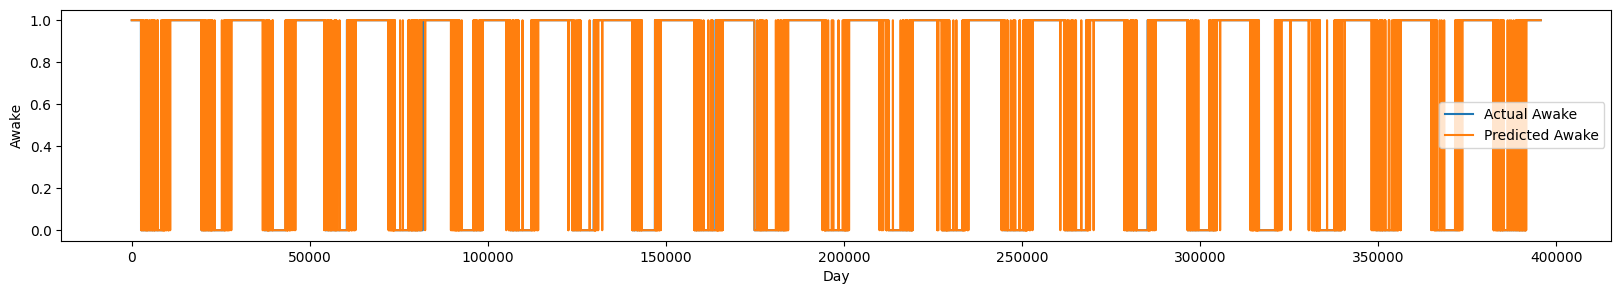

fetch ['c68260cc9e8f'] 



/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

accuracy: 0.93


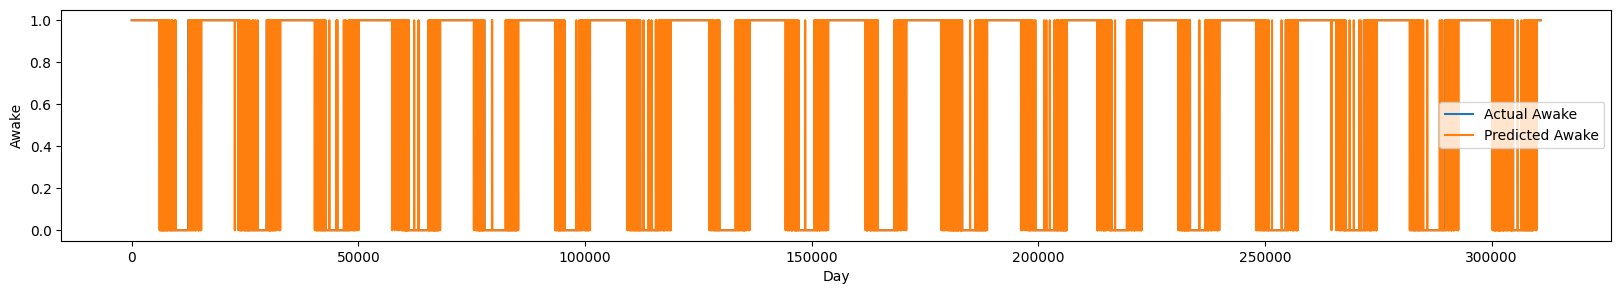

In [58]:
def predict_train_set(predict_series_ids):
    for series_id in predict_series_ids:
        pred_df = get_multi_light_series([series_id])
        pred_data = data_transform(pred_df)
        score, pred_value = predict(pred_data.to(def_device))
        act_y = tensor(pred_df["awake"].to_numpy())
        print(f"accuracy: {accuracy(score, act_y):.2f}")
        plot_predicate(pred_df["awake"], pred_value)


predict_train_set(train_ids[30:32])

In [59]:
del train_all, X_train, y_train
gc.collect()

3383

In [60]:
current_directory = os.getcwd()

parquet_file_path = os.path.join(
    current_directory, "input", "data", "test_series.parquet"
)


def get_test_series_ids():
    return pd.read_parquet(parquet_file_path, columns=["series_id"])[
        "series_id"
    ].unique()


def get_test_series(series_id):
    return pd.read_parquet(
        parquet_file_path,
        columns=["series_id", "timestamp", "anglez", "enmo", "step"],
        filters=[("series_id", "=", series_id)],
    )


def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(
        lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))
    ):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(["onset"] + (llg - 2) * [0] + ["wakeup"] if llg > 1 else [0])
    return lstPOI

In [61]:
def multi_series_prediction(test_series_ids):
    for series_id in test_series_ids:
        single_series = get_test_series(series_id)
        X_test = data_transform(single_series)
        score, _ = predict(X_test.to(def_device))

        single_series["not_awake"] = score[:, 0]
        single_series["awake"] = score[:, 1]

        smoothing_length = 2 * 230
        single_series["score"] = (
            single_series["awake"]
            .rolling(smoothing_length, center=True)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
        )
        single_series["smooth"] = (
            single_series["not_awake"]
            .rolling(smoothing_length, center=True)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
        )
        single_series["smooth"] = single_series["smooth"].round()
        single_series["event"] = get_event(single_series)

        df = (
            single_series.loc[single_series["event"] != 0][
                ["series_id", "step", "event", "score"]
            ]
            .copy()
            .reset_index(drop=True)
        )
        df.to_csv(f"{series_id}.csv", index=False)
        del df, single_series
        gc.collect()
    return


def combine_predictions(test_series):
    sub = pd.read_csv(f"{test_series[0]}.csv")
    for series in test_series[1:]:
        temp = pd.read_csv(f"{series}.csv")
        sub = pd.concat([sub, temp], ignore_index=True)
        del temp
        gc.collect()
    sub = sub.copy().reset_index(drop=True).reset_index(names="row_id")
    sub.to_csv("submission.csv", index=False)
    return sub

In [62]:
test_series_ids = get_test_series_ids()
test_series_ids

array(['038441c925bb', '03d92c9f6f8a', '0402a003dae9'], dtype=object)

In [63]:
multi_series_prediction(test_series_ids)
sub = combine_predictions(test_series_ids)
sub.head()

/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"]   = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill")
/var/folders/hb/_y1g8w4d6j910_w7_rr3vx700000gn/T/ipykernel_26663/2988593522.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float32')
/var/folders/hb/_y

,row_id,series_id,step,event,score


Logistic Regression Sleep State


In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


train_set, test_set = train_test_split(train_all, test_size=0.2)

In [87]:
features = [
    "step",
    "hour",
    "dayofweek",
    "anglez_times_enmo",
    "anglez",
    "anglez_diff",
    "anglez_mean",
    "anglez_min",
    "anglez_max",
    "anglez_std",
    "anglez_diff_rolling",
    "enmo",
    "enmo_diff",
    "enmo_mean",
    "enmo_min",
    "enmo_max",
    "enmo_std",
    "enmo_diff_rolling",
]
target = "awake"

scaler = StandardScaler()

df_train_X_scaled = scaler.fit_transform(train_all[features])
df_train_y = train_all[target].values


train_set[features]

,step,hour,dayofweek,anglez_times_enmo,anglez,anglez_diff,anglez_mean,anglez_min,anglez_max,anglez_std,anglez_diff_rolling,enmo,enmo_diff,enmo_mean,enmo_min,enmo_max,enmo_std,enmo_diff_rolling
1866979,-18977,8,4,0.49,-65.66,0.03,-65.67,-65.76,-65.66,0.04,0.03,0.01,0.00,0.01,0.01,0.01,0.00,-0.00
1095233,13433,12,2,0.00,18.57,11.71,14.10,7.96,18.57,4.00,10.34,0.00,-0.00,0.00,0.00,0.01,0.00,-0.01
1419002,9522,6,0,2.55,-34.05,25.52,-43.62,-59.52,-34.05,11.68,15.93,0.07,0.06,0.03,0.01,0.07,0.03,0.01
1362532,18588,0,4,0.31,3.59,1.67,3.36,0.33,7.16,2.33,2.23,0.09,-0.01,0.08,0.05,0.09,0.01,-0.02
363353,-29863,14,0,0.03,0.96,1.05,2.29,-6.91,8.21,5.65,32.36,0.03,-0.01,0.03,0.02,0.09,0.03,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249467,-28889,23,4,0.02,7.96,16.35,4.02,-4.33,9.28,5.92,-1.92,0.00,-0.01,0.01,0.00,0.02,0.01,-0.02
963395,4111,2,2,0.10,-6.13,27.57,-9.49,-20.40,1.18,7.79,21.58,0.02,-0.03,0.04,0.01,0.09,0.03,0.01
2215104,2284,23,2,0.37,8.82,-17.64,-1.03,-31.21,9.82,15.41,-23.68,0.04,0.04,0.03,0.01,0.08,0.03,0.03
1484405,9389,1,4,0.77,-11.00,-1.39,-7.27,-27.80,10.86,12.48,-2.34,0.07,-0.06,0.09,0.07,0.11,0.02,-0.12


In [92]:
model = LogisticRegression()
model.fit(train_set[features], train_set[target])
# model.fit(df_train_X_scaled, df_train_y)

LogisticRegression()

In [96]:
predictions = model.predict(test_set[features])

accuracy = np.mean(predictions == test_set[target])
print("Accuracy:", accuracy)

Accuracy: 0.8246230095961193


array([0, 0, 0, ..., 1, 1, 1], dtype=int16)

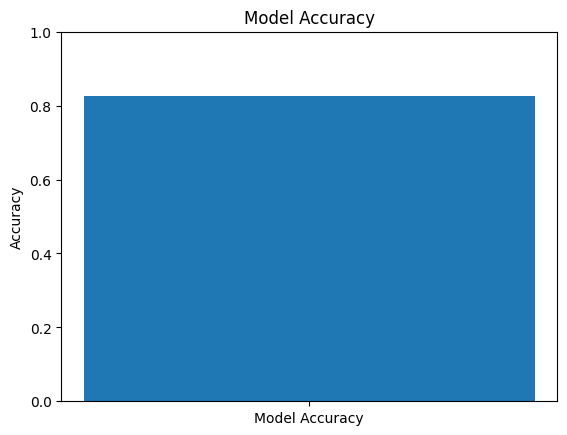

In [95]:
import matplotlib.pyplot as plt

# Plotting the accuracy
plt.bar(["Model Accuracy"], [accuracy])
plt.ylim(0, 1)  # Assuming accuracy is a fraction, set y-axis from 0 to 1
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

### Decision Tree (Decision Tree)

In [104]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay

In [105]:
acc_baseline = train_set[target].value_counts(normalize=True).max()
print("Baseline Accuracy: ", round(acc_baseline, 4))

Baseline Accuracy:  0.6695


In [108]:
model = make_pipeline(DecisionTreeClassifier(random_state=42))

model.fit(train_set[features], train_set[target])

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [109]:
# Determine model accuracy
acc_train = model.score(train_set[features], train_set[target])
acc_test = model.score(test_set[features], test_set[target])

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9909


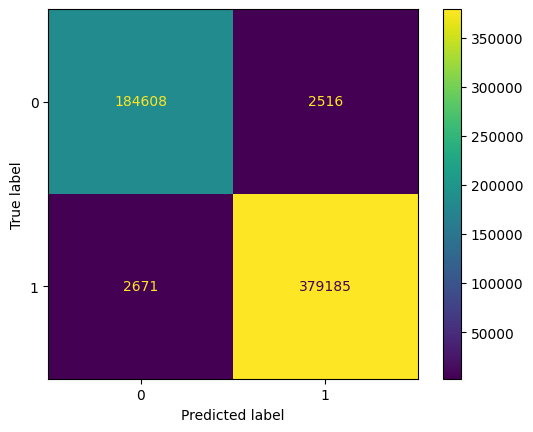

In [110]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix that shows how the model performs on the test set.
ConfusionMatrixDisplay.from_estimator(model, test_set[features], test_set[target]);

Precision and Recall


In [114]:
print(
    classification_report(
        test_set[target],
        model.predict(test_set[features]),
        target_names=["sleep onset", "wake"],
    )
)


model.predict(test_set[features])

              precision    recall  f1-score   support

 sleep onset       0.99      0.99      0.99    187124
        wake       0.99      0.99      0.99    381856

    accuracy                           0.99    568980
   macro avg       0.99      0.99      0.99    568980
weighted avg       0.99      0.99      0.99    568980



array([0, 0, 0, ..., 0, 1, 1], dtype=int16)

LightGBM (Light Gradient Boosting Machine)  

In [126]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import gc
import lightgbm as lgb
from sklearn.ensemble import BaggingClassifier, StackingClassifier
import lightgbm as lgbm
import time


classifier = lgbm.LGBMClassifier(
    n_estimatorsr=100,
    min_samples_leaf=300,
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
)

start = time.time()
classifier.fit(train_set[features], train_set[target])
end = time.time()

eta = int(end - start)

print(f"Done training in {eta}s")

[LightGBM] [Warning] Unknown parameter: n_estimatorsr
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] Unknown parameter: n_estimatorsr
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=300. Current value: min_data_in_leaf=300
[LightGBM] [Info] Number of positive: 1523756, number of negative: 752164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 2275920, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.669512 -> initscore=0.705979
[LightGBM] [Info] Start training from score 0.705979
Done training in 3s


In [127]:
print(
    classification_report(
        test_set[target],
        classifier.predict(test_set[features]),
        target_names=["sleep onset", "wake"],
    )
)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=300. Current value: min_data_in_leaf=300
[LightGBM] [Warning] Unknown parameter: n_estimatorsr
              precision    recall  f1-score   support

 sleep onset       0.95      0.96      0.95    187124
        wake       0.98      0.97      0.98    381856

    accuracy                           0.97    568980
   macro avg       0.96      0.97      0.96    568980
weighted avg       0.97      0.97      0.97    568980



In [130]:
def get_event(df):
    lstCV = zip(df.series_id, df.label)
    lstPOI = []
    for (c, v), g in groupby(
        lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))
    ):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(["onset"] + (llg - 2) * [0] + ["wakeup"] if llg > 1 else [0])
    return lstPOI


def predict_events(classifier, test, threshold=0.5, smoothing_length=None):
    test["score"] = classifier.predict_proba(test.drop("series_id", axis=1))[:, 0]

    # smoothing of the predictions
    if smoothing_length != None:
        test["smoothed_score"] = (
            test.groupby("series_id")["score"]
            .rolling(smoothing_length, center=True)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
            .values
        )

    test["label"] = 1 * (test.smoothed_score >= threshold)
    test["event"] = get_event(test)
    return test

In [134]:
train_event_preds = predict_events(
    classifier, train_all[["series_id"] + features], smoothing_length=smoothing_length
)
train_event_preds["timestamp"] = train["timestamp"]

t2 = time()
eta = int(t2 - t1)
print(f"Done predicting in {eta}s")

for chosen_series_id in series_with_least_steps:
    sample = train_all[train_all.series_id == chosen_series_id]
    sample_events = events[events.series_id == chosen_series_id]
    sample_event_preds = train_event_preds.loc[
        train_event_preds.series_id == chosen_series_id,
        ["timestamp", "series_id", "event", "score", "smoothed_score"],
    ]

    score = sample_event_preds.score
    sscore = sample_event_preds.smoothed_score
    sample_event_preds.drop(["score", "smoothed_score"], axis=1, inplace=True)

    t1 = time()
    plot_series_with_events(
        [sample.lids, score, sscore],
        sample.timestamp,
        events=sample_events,
        events_pred=sample_event_preds,
        min_vals=[0.0, 0.0, 0.0],
    )
    t2 = time()
    eta = int(t2 - t1)
    print(f"Done plot in {eta}s")

# del(train, events) # turn this on to reduce memory usage during submission
gc.collect()
# del(sample, train_event_preds, score, score, sample_events, sample_event_preds)

NameError: name 'smoothing_length' is not defined

In [135]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)

# Training classifier
rf_classifier = RandomForestClassifier(
    n_estimators=500, min_samples_leaf=25, random_state=42, n_jobs=-1
)

rf_classifier.fit(train_set[features], train_set[target])

RandomForestClassifier(min_samples_leaf=25, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [136]:
px.bar(
    x=features, y=classifier.feature_importances_, title="LightGBM feature importances"
)

In [138]:
px.bar(
    x=features,
    y=rf_classifier.feature_importances_,
    title="Random forest feature importances",
)

In [147]:
print(
    classification_report(
        test_set[target],
        rf_classifier.predict(test_set[features]),
        target_names=["sleep onset", "wake"],
    )
)

              precision    recall  f1-score   support

 sleep onset       0.96      0.96      0.96    187124
        wake       0.98      0.98      0.98    381856

    accuracy                           0.97    568980
   macro avg       0.97      0.97      0.97    568980
weighted avg       0.97      0.97      0.97    568980



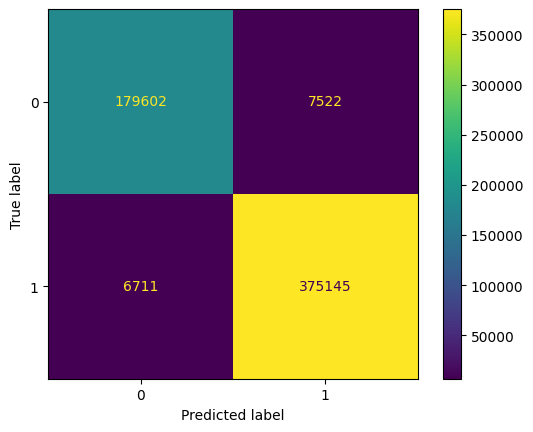

In [149]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix that shows how the model performs on the test set.
ConfusionMatrixDisplay.from_estimator(
    rf_classifier, test_set[features], test_set[target]
);

Index(['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'awake', 'hour',
       'dayofweek', 'anglez_times_enmo', 'anglez_diff', 'enmo_diff',
       'anglez_mean', 'enmo_mean', 'anglez_min', 'enmo_min', 'anglez_max',
       'enmo_max', 'anglez_std', 'enmo_std', 'anglez_diff_rolling',
       'enmo_diff_rolling'],
      dtype='object')